# Log Linear Modelling

Student: Luke Smith \\
Id:      17-323-635 \\
Email:   lusmith@student.ethz.ch \\

Notes:
I first implemented the LLM with softmax as described in the course, however this is much less efficient than using a LLM with sigmoid as we are in the binary classication case, hence I also implemented with sigmoid and will use that version in the latex for comparison.

In [ ]:
import random
import sys
from typing import Callable, List, Tuple

import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from scipy.special import softmax as scipysoftmax
from scipy.special import expit as scipysigmoid
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from timeit import default_timer as timer
from tqdm import tqdm
import contextlib

# Using google colab
from google.colab import drive
drive.mount('/content/gdrive')

# Set seeds to ensure reproducibility
np.random.seed(42)
random.seed(42)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Testing Function

In [ ]:
def test(X,y,llm,splits=10,dataset=1,save=False):

  # Open the write file or a null context to avoid overwriting the file
  with (open(f'/content/gdrive/My Drive/NLP/Dataset_{dataset}/results_{dataset}.txt', 'w') \
        if save else contextlib.nullcontext()) as f:

    # llm
    llm_train_time = []
    llm_predict_time_train = []
    llm_predict_time_test = []
    llm_acc_train = []
    llm_acc_test = []
    # lr
    lr_train_time = []
    lr_predict_time_train = []
    lr_predict_time_test = []
    lr_acc_train = []
    lr_acc_test = []

    ##########################################################
    #                       Get Results                      #
    ##########################################################
    for i in tqdm(range(splits)):
      X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

      #############################
      #           Train           #
      #############################
      # llm
      start = timer()
      llm.fit(X_train,y_train)
      end = timer()
      llm_train_time.append(end-start)

      # lr
      start = timer()
      lr.fit(X_train,y_train)
      end = timer()
      lr_train_time.append(end-start)

      #############################
      #          Predict          #
      #############################  
      # llm
      start = timer()
      pred_llm_test = llm.predict(X_test)
      end = timer()
      llm_predict_time_test.append(end-start)

      start = timer()
      pred_llm_train = llm.predict(X_train)
      end = timer()
      llm_predict_time_train.append(end-start)
      
      # lr
      start = timer()
      pred_lr_test = lr.predict(X_test)
      end = timer()
      lr_predict_time_test.append(end-start)

      start = timer()
      pred_lr_train = lr.predict(X_train)
      end = timer()
      lr_predict_time_train.append(end-start)

      #############################
      #            Test           #
      #############################
      # llm
      llm_acc_test.append(accuracy_score(y_test, pred_llm_test))
      llm_acc_train.append(accuracy_score(y_train, pred_llm_train))

      # lr
      lr_acc_test.append(accuracy_score(y_test, pred_lr_test))
      lr_acc_train.append(accuracy_score(y_train, pred_lr_train))


    ##########################################################
    #                 Display & Save Results                 #
    ##########################################################
    print('\n')

    #############################
    #         Accuracy          #
    #############################
    llm_avg_train_acc = np.mean(llm_acc_train)
    llm_avg_test_acc = np.mean(llm_acc_test)
    lr_avg_train_acc = np.mean(lr_acc_train)
    lr_avg_test_acc = np.mean(lr_acc_test)

    acc_res=f'\
    \n##############################################################################\n \
    Average Accuracy: \n \
    Train: \n \
        llm: {llm_avg_train_acc:.3f} \n \
        lr:  {lr_avg_train_acc:.3f} \n \
    Test: \n \
        llm: {llm_avg_test_acc:.2f} \n \
        lr:  {lr_avg_test_acc:.2f} \n \
    '
    print(acc_res)
    if save:
        f.write(acc_res)

    plt.figure()
    plt.title('Accuracy')
    plt.xlabel('Test Run #')
    plt.plot(llm_acc_train, label='llm train', color='r')
    plt.plot(lr_acc_train, label='lr train', color = 'b')
    plt.plot(llm_acc_test, label='llm test', color = 'tomato')
    plt.plot(lr_acc_test, label='lr test', color = 'royalblue')
    plt.legend()
    if save:
      plt.savefig(f'/content/gdrive/My Drive/NLP/Dataset_{dataset}/A1_Q2_Dataset{dataset}_Accuracy.png', bbox_inches='tight')
    plt.show()

    #############################
    #         Compute          #
    #############################
    llm_avg_train_time = np.mean(llm_train_time)
    llm_avg_predict_time_test = np.mean(llm_predict_time_test)
    llm_avg_predict_time_train = np.mean(llm_predict_time_train)
    lr_avg_train_time = np.mean(lr_train_time)
    lr_avg_predict_time_test = np.mean(lr_predict_time_test)
    lr_avg_predict_time_train = np.mean(lr_predict_time_train)

    comp_res=f'\
    \n##############################################################################\n \
    Average Computation Time: \n \
    Train: \n \
        llm: {llm_avg_train_time:.5f} \n \
        lr:  {lr_avg_train_time:.5f} \n \
    Predict: \n \
        Train: \n \
          llm: {llm_avg_predict_time_test:.7f} \n \
          lr:  {lr_avg_predict_time_test:.7f} \n \
        Test: \n \
          llm: {llm_avg_predict_time_train:.7f} \n \
          lr:  {lr_avg_predict_time_train:.7f} \n \
    '
    print(comp_res)
    if save:
      f.write(comp_res)

    plt.figure()
    plt.title('Computation Time: Train')
    plt.xlabel('Test Run #')
    plt.plot(llm_train_time, label='llm train', color='r')
    plt.plot(lr_train_time, label='lr train', color = 'b')
    plt.legend()
    if save:
      plt.savefig(f'/content/gdrive/My Drive/NLP/Dataset_{dataset}/A1_Q2_Dataset{dataset}_Compute_Train.png', bbox_inches='tight')
    plt.show()

    plt.figure()
    plt.title('Computation Time: Predict Train')
    plt.xlabel('Test Run #')
    plt.plot(llm_predict_time_test, label='llm predict', color = 'r')
    plt.plot(lr_predict_time_test, label='lr predict', color = 'b')
    plt.legend()
    if save:
      plt.savefig(f'/content/gdrive/My Drive/NLP/Dataset_{dataset}/A1_Q2_Dataset{dataset}_Compute_Compute_Predict_Train.png', bbox_inches='tight')
    plt.show()

    plt.figure()
    plt.title('Computation Time: Predict Test')
    plt.xlabel('Test Run #')
    plt.plot(llm_predict_time_train, label='llm predict', color = 'r')
    plt.plot(lr_predict_time_train, label='lr predict', color = 'b')
    plt.legend()
    if save:
      plt.savefig(f'/content/gdrive/My Drive/NLP/Dataset_{dataset}/A1_Q2_Dataset{dataset}_Compute_Compute_Predict_Test.png', bbox_inches='tight')
    plt.show()

    #############################
    #          Coeffs           #
    #############################
    # Makes more sense to compare the coefficients of the sigmoid implementation
    # (you can convert the softmax theta's into a correspoding sigmoid parameter
    # but it wasn't trained but I'm not including it in the report so no point)
    if llm.name == 'sigmoid':
      diff = llm_sigmoid.params - lr.coef_
      l2_diff = np.linalg.norm(diff)

      coeff_res=f'\
      \n##############################################################################\n \
      Coefficient Comparison: \n \
      Comparison: \n \
          L2 of difference:  {l2_diff} \n \
      '
      print(coeff_res)
      if save:
        f.write(coeff_res)

# Log Linear Model w/ Sigmoid



In [ ]:
class LogLinearModel_Sigmoid:
    def __init__(
        self,
        feature_function: Callable,
        learning_rate: float,
        iterations: int,
        loss: Callable,
        gradient_loss: Callable,
        verbose: bool,
    ):
        """
        Parameters
        ---
        feature_function : Callable
            Feature function mapping from X x Y -> R^m
        learning_rate : float
            Learning rate parameter eta for gradient descent
        iterations : int
            Number of iterations to run gradient descent for during `fit`
        loss : Callable
            Loss function to be used by this LogLinearModel instance as
            a function of the parameters and the data X and y
        gradient_loss : Callable
            Closed form gradient of the `loss` function used for gradient descent as
            a function of the parameters and the data X and y
        verbose : bool
            Verbosity level of the class. If verbose == True,
            the class will print updates about the gradient
            descent steps during `fit`

        """
        self.feature_function = feature_function
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.loss = loss
        self.gradient_loss = gradient_loss
        self.verbose = verbose
        self.params = None

        # Optimisations
        # Note: can increase training speed with a stopping criterion
        # self.tol = 1 # Seems quite high but performance doesn't increase much if we
                       # set it to 1e-4 for example, but training time does significantly

        # Meta
        self.name = 'sigmoid'

    def gradient_descent(self, X: np.ndarray, y: np.ndarray) -> float:
        gradient = self.gradient_loss(self,X,y)
        self.params -= self.learning_rate*gradient
        return np.max(gradient) # Used as stopping criterion

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:

        self.params = np.random.uniform(-1,1,X[0].shape)
        loss = []

        for i in range(self.iterations):
          max_grad = self.gradient_descent(X,y)
          # Stopping criterion
          # if max_grad < self.tol:
          #   break

          if self.verbose:
            params_old = self.params
            loss.append(self.loss(self,X,y))
            print(f'Iteration: {i} / {self.iterations}')
            if i > 1:
              print(f'Delta Loss: {loss[-1] - loss[-2]}')
              print(f'Largest Diff: {np.max(np.abs(params_old-self.params))}')
            print('\n')
          
    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.params is None:
          print("Model not fit yet")
          return None

        return (self.fast_predict(X)>0).astype(int)

    def fast_predict(self, X: np.ndarray) -> np.ndarray:
      """
      Prediction of the llm w/ sigmoid:
        y =  { 1  if (sigmoid(theta*X) > 0.5)
             { 0   else 
      Sigmoid is strictly monotone and 0.5 at 0 hence we only need to
      check if (theta*X) > 0
      """
      return self.apply_params(X)

    def predict_probs(self, X: np.ndarray) -> np.ndarray:
      y_01 = self.apply_params(X)
      return self.sigmoid(y_01)

    def apply_params(self, X: np.ndarray) -> np.ndarray:
      return np.dot(X,self.params)

    def sigmoid(self,x: np.ndarray) -> np.ndarray:
      # More numerically stable than if you write 1 / (1 + np.exp(-x))
      return scipysigmoid(x)

In [ ]:
def feature_function_sigmoid(X: np.ndarray, y: np.ndarray) -> np.ndarray:
  """
   Identity as sigmoid returns 'probability' between 0 and 1 which we will
   interpret as the probability of y=1
  """
  return X

def negative_log_likelihood_sigmoid(llm, X: np.ndarray, y: np.ndarray) \
                                                                  -> np.ndarray:
  preds = llm.predict_probs(X)
  log_preds = np.log(preds)
  correct_prediction_probs = y*log_preds + (1-y)*(1-log_preds)
  return -np.sum(np.log(correct_prediction_probs))

def gradient_negative_log_likelihood_sigmoid(llm, X: np.ndarray, y: np.ndarray)\
                                                                 -> np.ndarray:
  preds = llm.predict_probs(X)
  t = preds-y
  sum = np.array([np.sum(X[:,i]*t) for i in range(len(X[0]))])
  return sum

# Testing LLM w/ Sigmoid
The sigmoid implementation is far more efficient as it has many less operations to compute, hence we will look at that one in the report.

In [ ]:
max_it = 100
llm_sigmoid = LogLinearModel_Sigmoid(
    feature_function=feature_function_sigmoid,
    learning_rate=0.003,
    iterations=max_it,
    loss=negative_log_likelihood_sigmoid,
    gradient_loss=gradient_negative_log_likelihood_sigmoid,
    verbose = False
)
lr = LogisticRegression(max_iter=max_it)

## Dataset 1

100%|██████████| 100/100 [00:02<00:00, 35.61it/s]




    
##############################################################################
     Average Accuracy: 
     Train: 
         llm: 0.863 
         lr:  0.866 
     Test: 
         llm: 0.71 
         lr:  0.72 
     


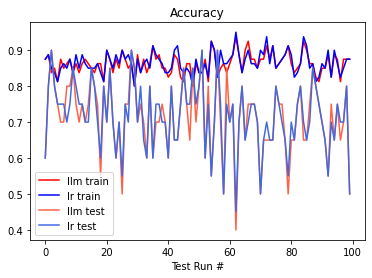

    
##############################################################################
     Average Computation Time: 
     Train: 
         llm: 0.01903 
         lr:  0.00709 
     Predict: 
         Train: 
           llm: 0.0000238 
           lr:  0.0001575 
         Test: 
           llm: 0.0000086 
           lr:  0.0000958 
     


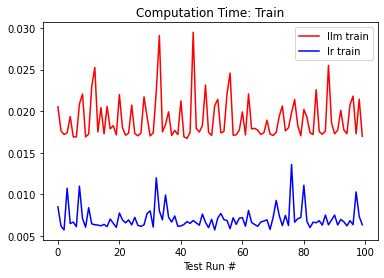

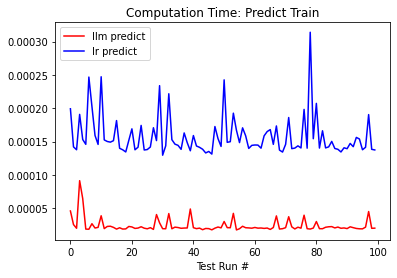

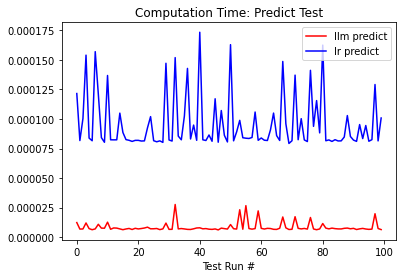

      
##############################################################################
       Coefficient Comparison: 
       Comparison: 
           L2 of difference:  0.18355975265022953 
       


In [ ]:
# First dataset
X, y = make_classification(
    n_samples=100, random_state=42, n_informative=20, n_features=20, n_redundant=0
)

test(X,y,llm_sigmoid,splits=100,dataset=1,save=True)

## Dataset 2

100%|██████████| 100/100 [00:09<00:00, 10.78it/s]




    
##############################################################################
     Average Accuracy: 
     Train: 
         llm: 0.738 
         lr:  0.816 
     Test: 
         llm: 0.73 
         lr:  0.80 
     


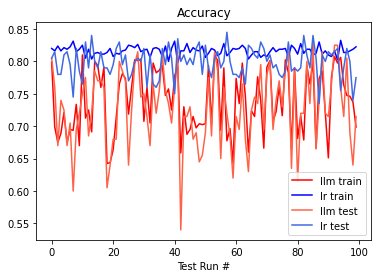

    
##############################################################################
     Average Computation Time: 
     Train: 
         llm: 0.06767 
         lr:  0.02027 
     Predict: 
         Train: 
           llm: 0.0000625 
           lr:  0.0002274 
         Test: 
           llm: 0.0000496 
           lr:  0.0001721 
     


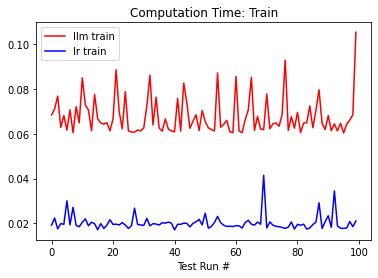

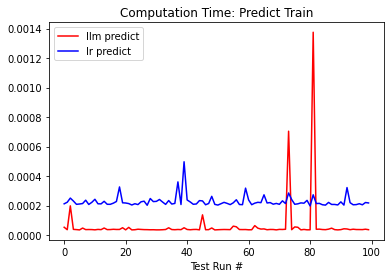

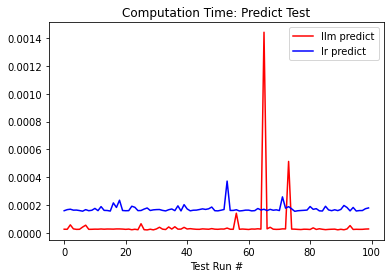

      
##############################################################################
       Coefficient Comparison: 
       Comparison: 
           L2 of difference:  13.917371637592046 
       


In [ ]:
# Second dataset
X, y = make_classification(
    n_samples=1000,
    random_state=42,
    n_informative=20,
    n_redundant=10,
    n_features=35,
    n_repeated=5,
)

test(X,y,llm_sigmoid,splits=100,dataset=2,save=True)

## Dataset 3

100%|██████████| 100/100 [00:17<00:00,  5.62it/s]




    
##############################################################################
     Average Accuracy: 
     Train: 
         llm: 0.855 
         lr:  0.890 
     Test: 
         llm: 0.85 
         lr:  0.89 
     


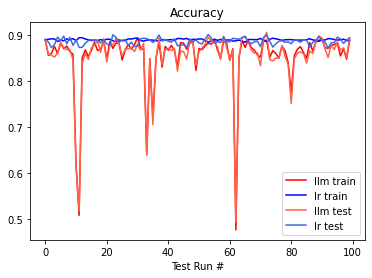

    
##############################################################################
     Average Computation Time: 
     Train: 
         llm: 0.14194 
         lr:  0.02220 
     Predict: 
         Train: 
           llm: 0.0000876 
           lr:  0.0003139 
         Test: 
           llm: 0.0000917 
           lr:  0.0003953 
     


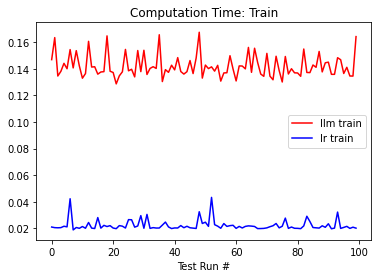

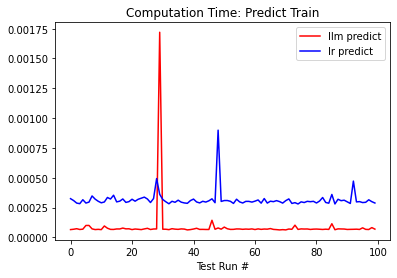

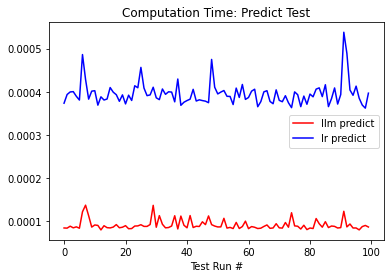

      
##############################################################################
       Coefficient Comparison: 
       Comparison: 
           L2 of difference:  17.706831252395798 
       


In [ ]:
# Third dataset
X, y = make_classification(
    n_samples=10000, random_state=42, n_informative=2, n_repeated=5
)

test(X,y,llm_sigmoid,splits=100,dataset=3,save=True)

# Log Linear Model w/ Softmax

In [ ]:
class LogLinearModel:
    def __init__(
        self,
        feature_function: Callable,
        learning_rate: float,
        iterations: int,
        loss: Callable,
        gradient_loss: Callable,
        verbose: bool,
    ):
        """
        Parameters
        ---
        feature_function : Callable
            Feature function mapping from X x Y -> R^m
        learning_rate : float
            Learning rate parameter eta for gradient descent
        iterations : int
            Number of iterations to run gradient descent for during `fit`
        loss : Callable
            Loss function to be used by this LogLinearModel instance as
            a function of the parameters and the data X and y
        gradient_loss : Callable
            Closed form gradient of the `loss` function used for gradient descent as
            a function of the parameters and the data X and y
        verbose : bool
            Verbosity level of the class. If verbose == True,
            the class will print updates about the gradient
            descent steps during `fit`

        """
        self.feature_function = feature_function
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.loss = loss
        self.gradient_loss = gradient_loss
        self.verbose = verbose
        self.params = None

        # Optimisations
        # Note: can increase training speed with a stopping criterion
        # self.tol = 1 # Seems quite high but performance doesn't increase much if we
                     # set it to 1e-4 for example, but training time does significantly
        # Avoid recomputing values, as we always train on the whole dataset
        # at each iteration we only need to compute the features once
        self.training = False
        self.features_y = None
        self.features_01 = None
        self.features_0 = None
        self.features_1 = None
        self.observed_feature_count = None # Used in the gradient_negative_log_likelihood function but is always the same

        # Meta
        self.name = 'softmax'

    def gradient_descent(self, X: np.ndarray, y: np.ndarray) -> float:
        gradient = self.gradient_loss(self,X,y)
        self.params -= self.learning_rate*gradient
        return np.max(gradient)


    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self.training = True
        self.features_0, self.features_1, self.features_01, self.features_y = self.get_training_features(X,y)
        self.params = np.random.uniform(-1,1,self.features_0[0].shape[0])
        self.observed_feature_count = -np.sum(self.features_y,axis=0)
        loss = []

        for i in range(self.iterations):

          max_grad = self.gradient_descent(X,y)
          # Stopping criterion
          # if max_grad < self.tol:
          #   break

          if self.verbose:
            params_old = self.params
            loss.append(self.loss(self,X,y))
            print(f'Iteration: {i} / {self.iterations}')
            if i > 1:
              print(f'Delta Loss: {loss[-1] - loss[-2]}')
              print(f'Largest Diff: {np.max(np.abs(params_old-self.params))}')
            print('\n')
          
        self.training = False

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.params is None:
          print("Model not fit yet")
          return None

        return np.argmax(self.fast_predict(X),axis=1)

    def fast_predict(self, X: np.ndarray) -> np.ndarray:
      # Softmax doesn't affect argmax for binary case hence can predict without
      return self.apply_params(X)

    def predict_probs(self, X: np.ndarray) -> np.ndarray:
      y_01 = self.apply_params(X)
      return self.softmax(y_01)

    def apply_params(self, X: np.ndarray) -> np.ndarray:
      # Helper for the predict functions, dot's with parameters
      if self.training:
        y_0 = np.dot(self.features_0,self.params)
        y_1 = np.dot(self.features_1,self.params)
      else:
        y_0 = np.dot(self.feature_function(X,np.zeros(X.shape[0])),self.params)
        y_1 = np.dot(self.feature_function(X,np.ones(X.shape[0])),self.params)
      return np.column_stack((y_0,y_1))

    def get_training_features(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray]:
      # Save all the reused features during training
      f_0 = self.feature_function(X,np.zeros(X.shape[0]))
      f_1 = self.feature_function(X,np.ones(X.shape[0]))
      f_01 = np.column_stack((f_0,f_1))
      f_y = self.feature_function(X,y)
      return f_0, f_1, f_01, f_y

    def softmax(self,x: np.ndarray) -> np.ndarray:
      # For numerical stability and speed I simply use the scipy implementation
      # which I beleive is allowed, if not my implementation is below
      return scipysoftmax(x,axis=1)
            
    # def softmax(self,x: np.ndarray) -> np.ndarray:
    #   # My slow and unstable implementation of the softmax function
    #   exp_x = np.exp(x)
    #   exp_sum = np.sum(np.exp(x),axis=1)
    #   soft = np.array([np.array([x[0]/y,x[1]/y]) for x,y in zip(exp_x,exp_sum)])
    #   return soft

In [ ]:
def feature_function(X: np.ndarray, y: np.ndarray) -> np.ndarray:
  """
  Put the x values in the left (y=0) of an array or in the right (y=1)
  [x,0,...,0] or [0,...,0,x]
  This results in us essentially having a parameter corresponding to y=0 and one
  to y=1
  Note: the function only works for arrays not individual items
  """
  padding = np.zeros(len(X[0]))
  features = np.array([np.concatenate((padding,X[i])) if y[i] == 1 \
                      else np.concatenate((X[i],padding)) \
                      for i in range(len(y))])
  return features

def negative_log_likelihood(llm, X: np.ndarray, y: np.ndarray) -> np.ndarray:
  log_predictions = np.log(llm.predict_probs(X))
  return -np.sum(log_predictions[np.arange(len(y)),y]) # Indexes the correct predictions probabilities

def gradient_negative_log_likelihood(llm, X: np.ndarray, y: np.ndarray) -> np.ndarray:
  """
  Calculates the gradient of the log linear model for the nll loss
  as described on 'p.45 Lecture 3'
  """
  predictions = llm.predict_probs(X)
  expected_feature_count = np.sum(np.array([llm.features_0[i]*predictions[:,0][i]\
                                            + llm.features_1[i]*predictions[:,1][i]\
                                            for i in range(len(llm.features_0))])\
                                  , axis = 0)
  return llm.observed_feature_count + expected_feature_count

# Testing LLM w/ Softmax

In [ ]:
max_it = 100
llm_softmax = LogLinearModel(
    feature_function=feature_function,
    learning_rate=0.003,
    iterations=max_it,
    loss=negative_log_likelihood,
    gradient_loss=gradient_negative_log_likelihood,
    verbose = False
)
lr = LogisticRegression(max_iter=max_it)

## Dataset 1

100%|██████████| 30/30 [00:02<00:00, 12.85it/s]




    
##############################################################################
     Average Accuracy: 
     Train: 
         llm: 0.860 
         lr:  0.860 
     Test: 
         llm: 0.75 
         lr:  0.76 
     


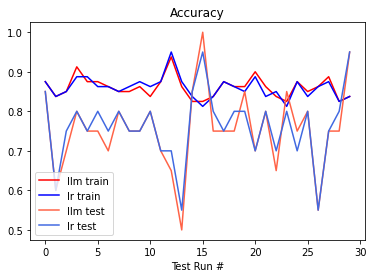

    
##############################################################################
     Average Computation Time: 
     Train: 
         llm: 0.06716 
         lr:  0.00735 
     Predict: 
         Train: 
           llm: 0.0002358 
           lr:  0.0001711 
         Test: 
           llm: 0.0006239 
           lr:  0.0001016 
     


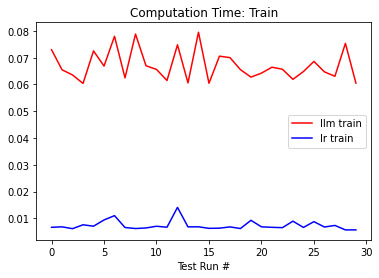

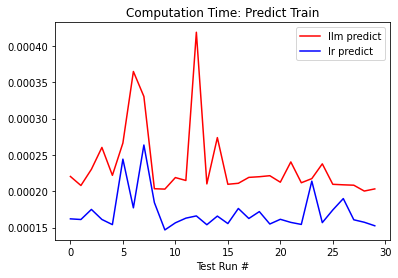

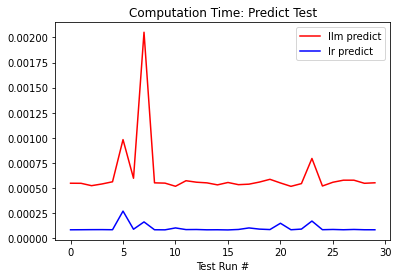

In [ ]:
# First dataset
X, y = make_classification(
    n_samples=100, random_state=42, n_informative=20, n_features=20, n_redundant=0
)

test(X,y,llm_softmax,splits=30,dataset=1,save=False)

## Dataset 2

100%|██████████| 30/30 [00:29<00:00,  1.02it/s]




    
##############################################################################
     Average Accuracy: 
     Train: 
         llm: 0.746 
         lr:  0.816 
     Test: 
         llm: 0.74 
         lr:  0.80 
     


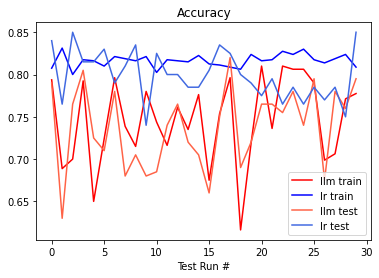

    
##############################################################################
     Average Computation Time: 
     Train: 
         llm: 0.94127 
         lr:  0.02018 
     Predict: 
         Train: 
           llm: 0.0023844 
           lr:  0.0003471 
         Test: 
           llm: 0.0090369 
           lr:  0.0002740 
     


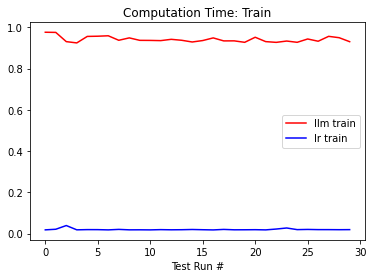

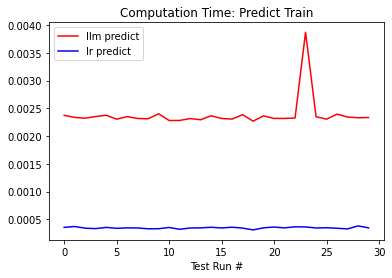

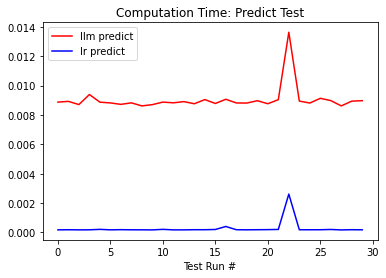

In [ ]:
# Second dataset
X, y = make_classification(
    n_samples=1000,
    random_state=42,
    n_informative=20,
    n_redundant=10,
    n_features=35,
    n_repeated=5,
)

test(X,y,llm_softmax,splits=30,dataset=2,save=False)

## Dataset 3

100%|██████████| 30/30 [04:26<00:00,  8.88s/it]




    
##############################################################################
     Average Accuracy: 
     Train: 
         llm: 0.831 
         lr:  0.890 
     Test: 
         llm: 0.83 
         lr:  0.89 
     


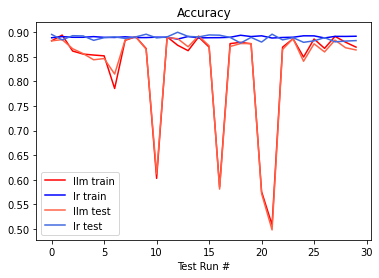

    
##############################################################################
     Average Computation Time: 
     Train: 
         llm: 8.73830 
         lr:  0.02098 
     Predict: 
         Train: 
           llm: 0.0217648 
           lr:  0.0007171 
         Test: 
           llm: 0.0869570 
           lr:  0.0005426 
     


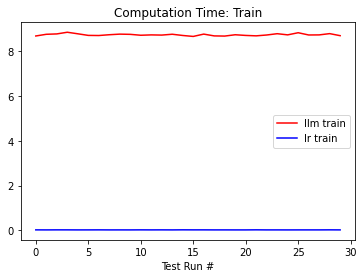

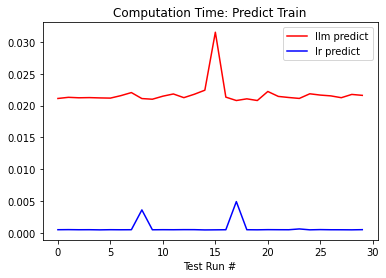

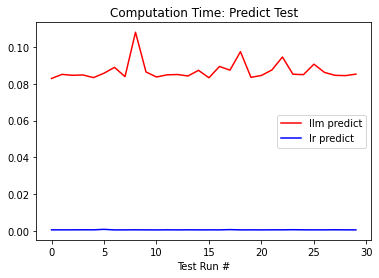

In [ ]:
# Third dataset
X, y = make_classification(
    n_samples=10000, random_state=42, n_informative=2, n_repeated=5
)

test(X,y,llm_softmax,splits=30,dataset=3,save=False)